In [ ]:
# Step 1: Install necessary libraries
!pip install transformers datasets scikit-learn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.3/474.3 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 8.4 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyarrow 17.0.0 which is incompatible.


In [ ]:
# Step 2: Import necessary libraries
import numpy as np
import pandas as pd
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving xstest_test_clean.csv to xstest_test_clean.csv
Saving xstest_train_clean.csv to xstest_train_clean.csv


In [ ]:
# Step 3: Load the training and testing datasets
train_df = pd.read_csv('xstest_train_clean.csv')
test_df = pd.read_csv('xstest_test_clean.csv')


In [ ]:
# Convert the Pandas DataFrame to Hugging Face Dataset format
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)


In [ ]:
# Step 4: Load the tokenizer and model
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
tokenizer.add_special_tokens({'pad_token': '[PAD]'})  # Add padding token explicitly

model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Step 5: Preprocess the data (tokenize text)
def preprocess_function(examples):
    return tokenizer(examples['prompt'], padding="max_length", truncation=True, max_length=128)

In [ ]:
# Apply preprocessing to both train and test datasets
tokenized_train = train_dataset.map(preprocess_function, batched=True)
tokenized_test = test_dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/360 [00:00<?, ? examples/s]

Map:   0%|          | 0/90 [00:00<?, ? examples/s]

In [ ]:
# Rename the 'label' column to 'labels' for compatibility with Trainer
tokenized_train = tokenized_train.rename_column("label", "labels")
tokenized_test = tokenized_test.rename_column("label", "labels")

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import numpy as np

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)

    # Compute standard metrics
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary', zero_division=1)
    acc = accuracy_score(labels, preds)

    # Compute confusion matrix
    cm = confusion_matrix(labels, preds)

    # Print confusion matrix
    print("Confusion Matrix:\n", cm)

    # Return metrics
    return {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'confusion_matrix': cm
    }



In [ ]:
# Step 7: Set training arguments
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
# Step 8: Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    compute_metrics=compute_metrics  # Custom evaluation metrics function
)

In [ ]:
# Step 9: Train the model
trainer.train()


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Confusion Matrix 00,Confusion Matrix 01,Confusion Matrix 10,Confusion Matrix 11
1,No log,0.633781,0.644444,0.652174,0.652174,0.652174,28,16,16,30
2,No log,0.563440,0.677778,0.666667,0.739130,0.701031,27,17,12,34
3,No log,0.535254,0.700000,0.711111,0.695652,0.703297,31,13,14,32


Confusion Matrix:
 [[28 16]
 [16 30]]
Confusion Matrix:
 [[27 17]
 [12 34]]
Confusion Matrix:
 [[31 13]
 [14 32]]


TrainOutput(global_step=135, training_loss=0.540179951985677, metrics={'train_runtime': 829.2459, 'train_samples_per_second': 1.302, 'train_steps_per_second': 0.163, 'total_flos': 35766197637120.0, 'train_loss': 0.540179951985677, 'epoch': 3.0})

In [ ]:
# Step 10: Evaluate the model
results = trainer.evaluate()


Confusion Matrix:
 [[31 13]
 [14 32]]


In [ ]:
# Step 11: Print evaluation results
print(results)


{'eval_loss': 0.535254180431366, 'eval_accuracy': 0.7, 'eval_precision': 0.7111111111111111, 'eval_recall': 0.6956521739130435, 'eval_f1': 0.7032967032967032, 'eval_confusion_matrix_00': 31, 'eval_confusion_matrix_01': 13, 'eval_confusion_matrix_10': 14, 'eval_confusion_matrix_11': 32, 'eval_runtime': 17.407, 'eval_samples_per_second': 5.17, 'eval_steps_per_second': 0.689, 'epoch': 3.0}


Confusion Matrix:
 [[31 13]
 [14 32]]


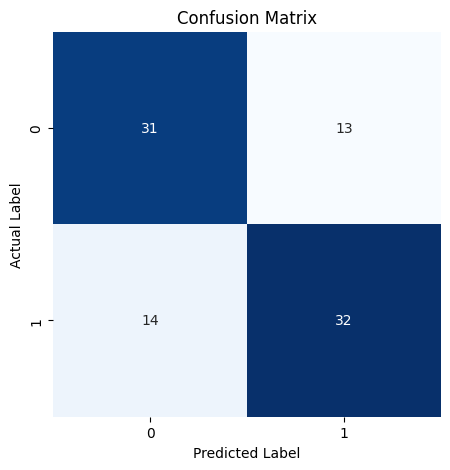

{'test_loss': 0.535254180431366, 'test_accuracy': 0.7, 'test_precision': 0.7111111111111111, 'test_recall': 0.6956521739130435, 'test_f1': 0.7032967032967032, 'test_confusion_matrix_00': 31, 'test_confusion_matrix_01': 13, 'test_confusion_matrix_10': 14, 'test_confusion_matrix_11': 32, 'test_runtime': 32.4378, 'test_samples_per_second': 2.775, 'test_steps_per_second': 0.37}


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Evaluate the model
predictions = trainer.predict(tokenized_test)

# Extract the true labels and predicted labels
true_labels = predictions.label_ids
predicted_labels = predictions.predictions.argmax(-1)

# Compute the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()

# Print evaluation results
print(predictions.metrics)
